# Load a model and fold in uncertainties

In [1]:
import sys
import os
import numpy as np
np.random.seed(42)

import tensorflow as tf
from tensorflow import keras
from bumps.initpop import lhs_init
import pandas as pd

import json
import refl1d
from refl1d.names import *

from matplotlib import pyplot as plt
import matplotlib.lines as mlines
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')


In [2]:
# Directory in which the code sits
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'ml-nr-two-layers')

# Data directory
data_dir = os.path.join(git_dir, 'data')

In [3]:
# Path to our test data
haynes = os.path.join(data_dir, 'haynes_off_off_v2.dat')

In [4]:
sys.path.append(git_dir)

import reflectivity_model_haynes
import importlib
importlib.reload(reflectivity_model_haynes)

<module 'reflectivity_model_haynes' from '/Users/m2d/git/ml-nr-two-layers/reflectivity_model_haynes.py'>

In [5]:
# Load some data to define the q axis
data_off = np.loadtxt(os.path.join(data_dir, "haynes_off_off_v2.dat")).T
q_ref = data_off[0]

In [6]:
m = reflectivity_model_haynes.ReflectivityModels(q=q_ref)

model = reflectivity_model_haynes.load_model('haynes', os.path.join(data_dir, 'training_data'))

# Apply model to read data and get prediction

Prediction: [ 12.03071594   7.72461605 155.30010986  22.15903854   4.70563984
 210.59483337  24.74413681]
Chi2(pred) = 4.99091
Chi2(fit) = 1.21117


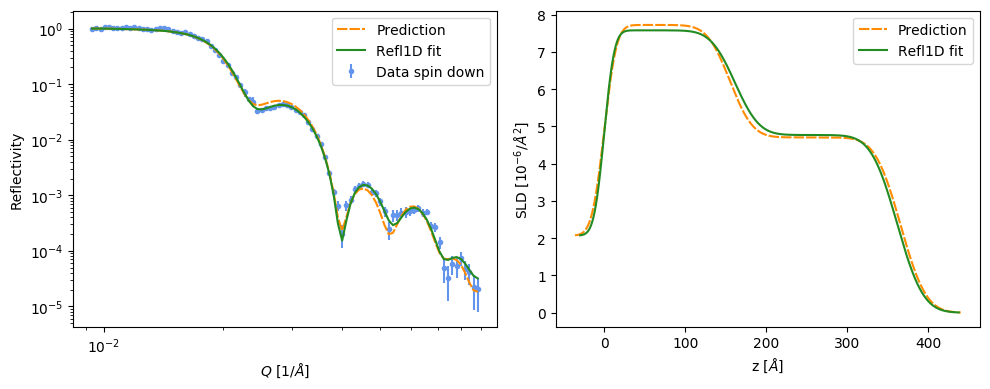

In [7]:
data_off = np.loadtxt(os.path.join(data_dir, "haynes_off_off_v2.dat")).T
data_off[1][-1] = data_off[1][-1]*2

#data_off_proc = np.log10(data_off[1]*m.q**4/m.q[0]**4)
#data_off_proc = -np.log10(data_off[1]*m.q**4)
data_off_proc = np.log10(data_off[1]*m.q**2/m.q[0]**2)
preds = model.predict(np.asarray([data_off_proc]))


model_pars = m.to_model_parameters(preds)
_desc = m.get_model_description(model_pars[0])
iq_pred_data, z_pred_data, sld_pred_data = reflectivity_model_haynes.calculate_reflectivity(m.q, _desc)


print("Prediction: %s" % model_pars[0])
pars_values = [9.9,  7.58, 161.4, 23.6, 4.77, 200.3, 25.3]
_desc = m.get_model_description(pars_values)

iq_fit, z_fit, sld_fit = reflectivity_model_haynes.calculate_reflectivity(m.q, _desc)

chi_pred = np.sum((data_off[1]-iq_pred_data)**2/data_off[2]**2)/len(data_off[2])
chi_fit = np.sum((data_off[1]-iq_fit)**2/data_off[2]**2)/len(data_off[2])

print("Chi2(pred) = %g" % chi_pred)
print("Chi2(fit) = %g" % chi_fit)

linestyle = (0, (5, 1))

fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, dpi=100, figsize=[10,4])
ax = plt.subplot(1, 2, 1)

plt.loglog(m.q, iq_pred_data, label="Prediction", linestyle=linestyle, color='darkorange')
plt.loglog(m.q, iq_fit, label="Refl1D fit", color='forestgreen')
plt.errorbar(m.q, data_off[1], data_off[2], marker=".", linestyle='', 
             label='Data spin down', color='cornflowerblue', zorder=-1)

plt.gca().legend()
plt.xlabel('$Q$ [$1/\AA$]')
plt.ylabel('Reflectivity')
#plt.text(0.01, 2e-7, '(a)', fontsize=12)


ax = plt.subplot(1, 2, 2)
plt.plot(z_pred_data, sld_pred_data, label="Prediction", linestyle=linestyle, color='darkorange')
plt.plot(z_fit, sld_fit, label="Refl1D fit", color='forestgreen')
plt.gca().legend()
plt.xlabel('z [$\AA$]')
plt.ylabel('SLD [$10^{-6}/\AA^2$]')
#plt.text(-20, 0.6, '(b)', fontsize=12)

plt.show()

Prediction: [ 10.61899471   6.83336353 157.20680237  20.82331467   4.68938446
 210.6416626   24.01354599]
Chi2(pred) = 3.84954
Chi2(fit) = 0.985845


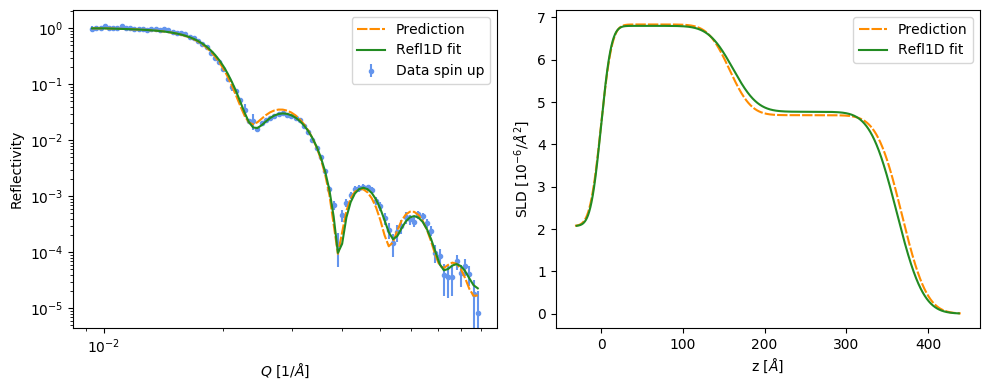

In [8]:
data_on = np.loadtxt(os.path.join(data_dir, "haynes_on_off_v2.dat")).T

data_on_proc = np.log10(data_on[1]*q_ref**2/q_ref[0]**2)


preds = model.predict(np.asarray([data_on_proc]))

model_pars = m.to_model_parameters(preds)
_desc = m.get_model_description(model_pars[0])
iq_pred_data, z_pred_data, sld_pred_data = reflectivity_model_haynes.calculate_reflectivity(m.q, _desc)


print("Prediction: %s" % model_pars[0])

pars_values = [9.9,  6.80, 161.4, 23.6, 4.77, 200.3, 25.3]
_desc = m.get_model_description(pars_values)

iq_fit, z_fit, sld_fit = reflectivity_model_haynes.calculate_reflectivity(m.q, _desc)

chi_pred = np.sum((data_on[1]-iq_pred_data)**2/data_on[2]**2)/len(data_on[2])
chi_fit = np.sum((data_on[1]-iq_fit)**2/data_on[2]**2)/len(data_on[2])

print("Chi2(pred) = %g" % chi_pred)
print("Chi2(fit) = %g" % chi_fit)

linestyle = (0, (5, 1))

fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, dpi=100, figsize=[10,4])
ax = plt.subplot(1, 2, 1)

plt.loglog(m.q, iq_pred_data, label="Prediction", linestyle=linestyle, color='darkorange')
plt.loglog(m.q, iq_fit, label="Refl1D fit", color='forestgreen')
plt.errorbar(m.q, data_on[1], data_on[2], marker=".", linestyle='', 
             label='Data spin up', color='cornflowerblue', zorder=-1)

plt.gca().legend()
plt.xlabel('$Q$ [$1/\AA$]')
plt.ylabel('Reflectivity')
#plt.text(0.01, 2e-7, '(a)', fontsize=12)


ax = plt.subplot(1, 2, 2)
plt.plot(z_pred_data, sld_pred_data, label="Prediction", linestyle=linestyle, color='darkorange')
plt.plot(z_fit, sld_fit, label="Refl1D fit", color='forestgreen')
plt.gca().legend()
plt.xlabel('z [$\AA$]')
plt.ylabel('SLD [$10^{-6}/\AA^2$]')
#plt.text(-20, 0.6, '(b)', fontsize=12)

plt.show()

# Fold in statistical uncertainties

In [9]:
%%time

def generate_noise(meas, n=20, label='down'):
    sld_top = []
    sld_bottom = []
    thick_top = []
    thick_bottom = []

    rough_top = []
    rough_bottom = []
    rough_sub = []

    logp = []
    for i in range(n):
        _data = meas[1] + np.random.normal(size=len(meas[2])) * meas[2]
        # Catch the few cases where we generated a negative intensity and take
        # the absolute value
        _data[_data<0] = np.fabs(_data[_data<0])
        _data_proc = np.log10(_data*q_ref**2/q_ref[0]**2)
        
        _preds = model.predict(np.asarray([_data_proc]))
        preds = m.to_model_parameters(_preds)
        
        sld_bottom.append(preds[0][1])
        sld_top.append(preds[0][4])
        thick_bottom.append(preds[0][2])
        thick_top.append(preds[0][5])

        rough_top.append(preds[0][6])
        rough_bottom.append(preds[0][3])
        rough_sub.append(preds[0][0])

        _desc = m.get_model_description(preds[0])
        _iq, _, _ = reflectivity_model_haynes.calculate_reflectivity(m.q, _desc, sld=False)

        # Note: The plot of -log(P) with be computed with a 10% error
        _logp =0.5 * np.sum((_iq - meas[1])**2/meas[2]**2) / len(_iq)
        #tset2.probability(_iq, sigma=None)
        logp.append(_logp)
    
    np.save(data_dir+'/training_data/haynes_noise_%s' % label, [logp, sld_bottom, sld_top, thick_bottom, thick_top,
                                        rough_bottom, rough_top, rough_sub])
    return logp, sld_bottom, sld_top, thick_bottom, thick_top, rough_bottom, rough_top, rough_sub
    

#generate_noise(data_off, 20000, label='down')
logp, sld_bottom, sld_top, thick_bottom, thick_top, \
    rough_bottom, rough_top, rough_sub = np.load(data_dir+'/training_data/haynes_noise_down.npy')

#generate_noise(data_on, 20000, label='up')
logp_up, sld_bottom_up, sld_top_up, thick_bottom_up, thick_top_up, \
    rough_bottom_up, rough_top_up, rough_sub_up = np.load(data_dir+'/training_data/haynes_noise_up.npy')

CPU times: user 1.2 ms, sys: 2.34 ms, total: 3.54 ms
Wall time: 2.53 ms


# Distribution of solutions from sample with uncertainties

total solutions: 20000 20000 20000 20000
SPIN DOWN


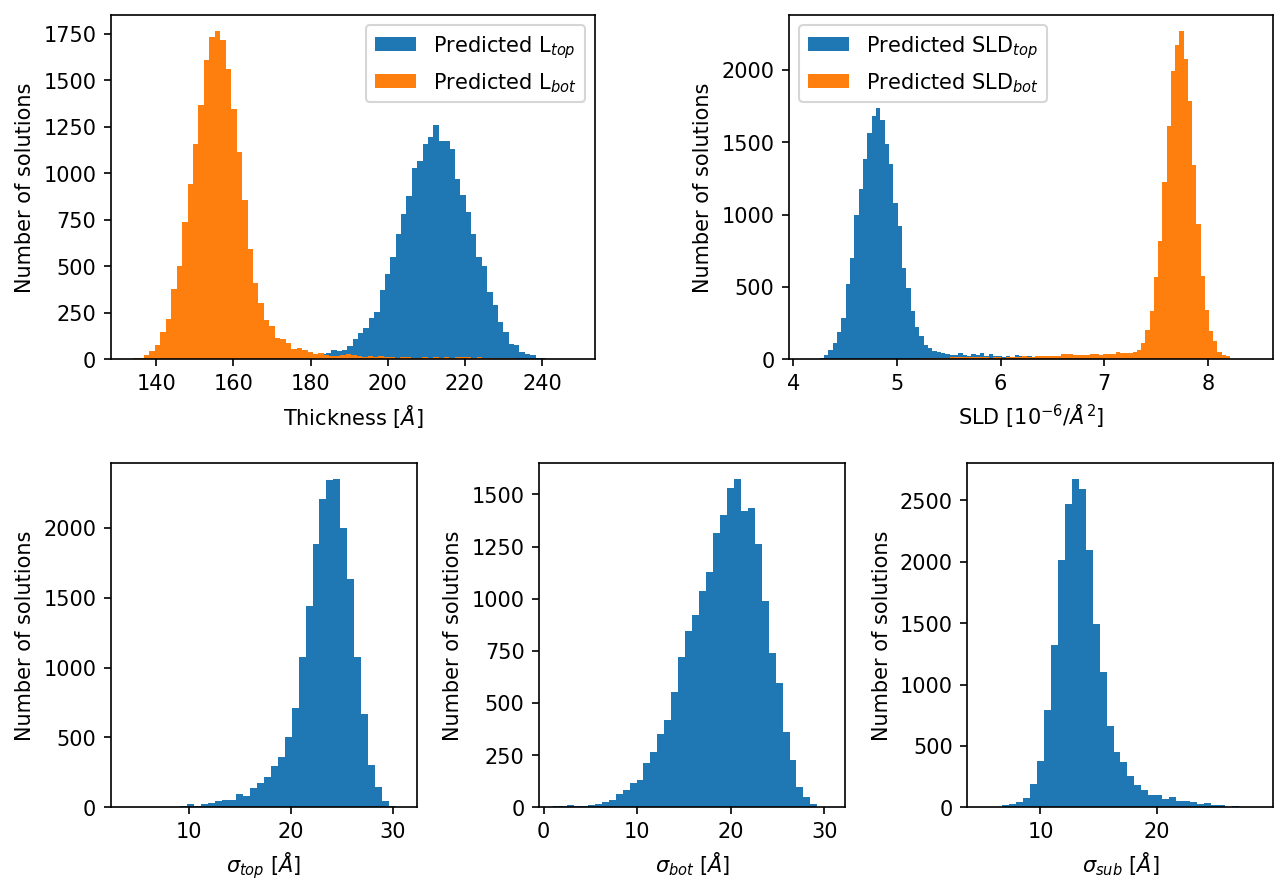

In [17]:
n_bins=40

# Sanity check
print("total solutions: %g %g %g %g" % (len(thick_top), len(thick_bottom),
                                       len(sld_top), len(sld_bottom)))

print("SPIN DOWN")
# 1D distribution of thickness values
fig, axs = plt.subplots(2, 2, sharey=False, tight_layout=True, dpi=150, figsize=(10,7))
fig.subplots_adjust(hspace=.3, wspace=0.4)

ax = plt.subplot(2, 2, 1)
ax.hist(thick_top, bins=n_bins*2, label="Predicted L$_{top}$")
ax.hist(thick_bottom, bins=n_bins*2, label="Predicted L$_{bot}$")

plt.gca().legend(loc='upper right')
plt.xlabel('Thickness [$\AA$]')
plt.ylabel('Number of solutions')

# 1D distribution of SLD values
ax = plt.subplot(2, 2, 2)
ax.hist(sld_top, bins=n_bins*2, label="Predicted SLD$_{top}$")
ax.hist(sld_bottom, bins=n_bins*2, label="Predicted SLD$_{bot}$")

plt.gca().legend(loc='upper left')
plt.xlabel('SLD [$10^{-6}/\AA^2$]')
plt.ylabel('Number of solutions')


ax = plt.subplot(2, 3, 4)
ax.hist(rough_top, bins=n_bins)
plt.xlabel('$\sigma_{top}$ [$\AA$]')
plt.ylabel('Number of solutions')

ax = plt.subplot(2, 3, 5)
ax.hist(rough_bottom, bins=n_bins)
plt.xlabel('$\sigma_{bot}$ [$\AA$]')
plt.ylabel('Number of solutions')

ax = plt.subplot(2, 3, 6)
ax.hist(rough_sub, bins=n_bins)
plt.xlabel('$\sigma_{sub}$ [$\AA$]')
plt.ylabel('Number of solutions')

plt.show()


total solutions: 20000 20000 20000 20000
SPIN DOWN


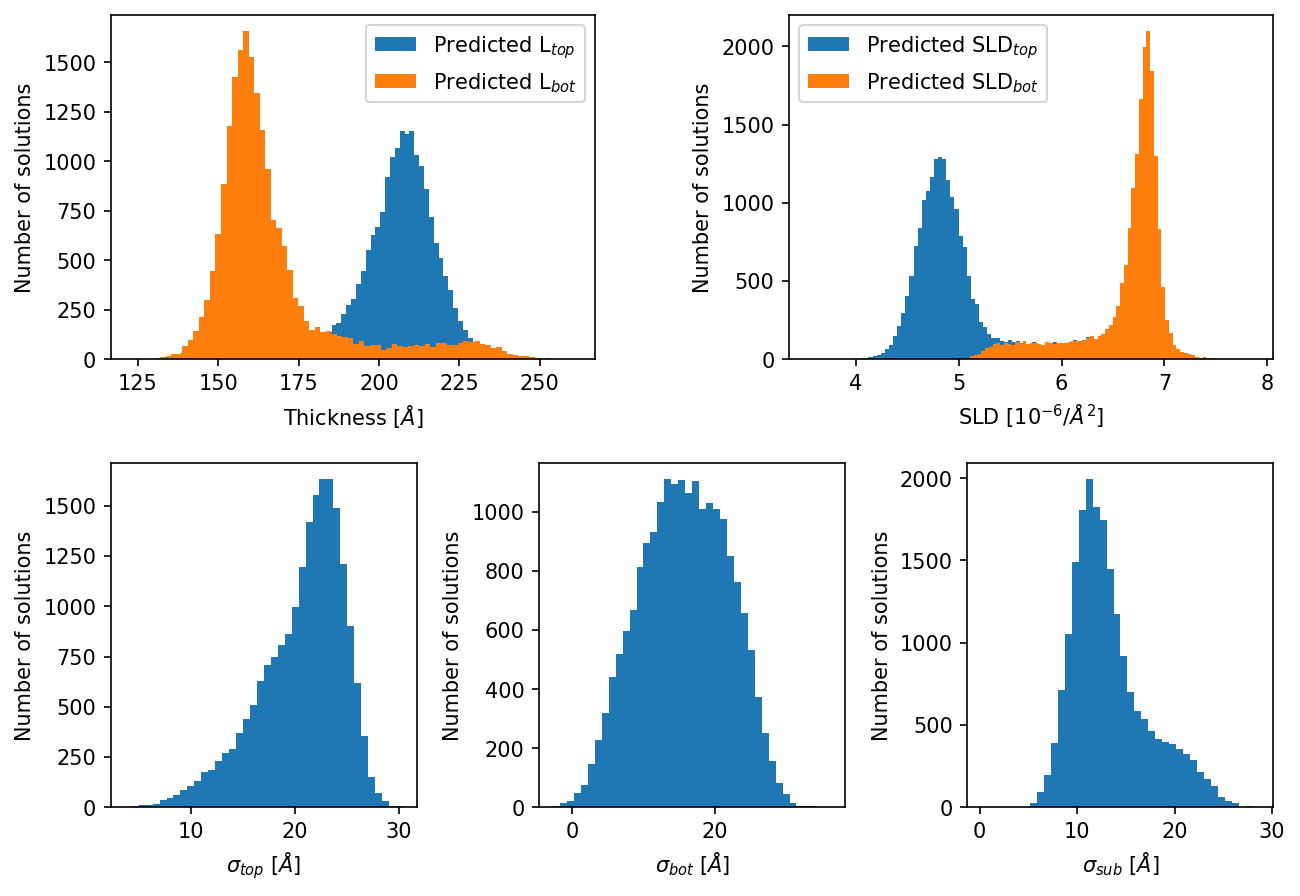

In [16]:
n_bins=40

# Sanity check
print("total solutions: %g %g %g %g" % (len(thick_top_up), len(thick_bottom_up),
                                       len(sld_top_up), len(sld_bottom_up)))

print("SPIN DOWN")
# 1D distribution of thickness values
fig, axs = plt.subplots(2, 2, sharey=False, tight_layout=True, dpi=150, figsize=(10,7))
fig.subplots_adjust(hspace=.3, wspace=0.4)

ax = plt.subplot(2, 2, 1)
ax.hist(thick_top_up, bins=n_bins*2, label="Predicted L$_{top}$")
ax.hist(thick_bottom_up, bins=n_bins*2, label="Predicted L$_{bot}$")
plt.gca().legend(loc='upper right')
plt.xlabel('Thickness [$\AA$]')
plt.ylabel('Number of solutions')

# 1D distribution of SLD values
ax = plt.subplot(2, 2, 2)
ax.hist(sld_top_up, bins=n_bins*2, label="Predicted SLD$_{top}$")
ax.hist(sld_bottom_up, bins=n_bins*2, label="Predicted SLD$_{bot}$")
plt.gca().legend(loc='upper left')
plt.xlabel('SLD [$10^{-6}/\AA^2$]')
plt.ylabel('Number of solutions')


ax = plt.subplot(2, 3, 4)
ax.hist(rough_top_up, bins=n_bins)
plt.xlabel('$\sigma_{top}$ [$\AA$]')
plt.ylabel('Number of solutions')

ax = plt.subplot(2, 3, 5)
ax.hist(rough_bottom_up, bins=n_bins)
plt.xlabel('$\sigma_{bot}$ [$\AA$]')
plt.ylabel('Number of solutions')

ax = plt.subplot(2, 3, 6)
ax.hist(rough_sub_up, bins=n_bins)
plt.xlabel('$\sigma_{sub}$ [$\AA$]')
plt.ylabel('Number of solutions')

plt.show()


In [15]:
print("Spin down prediction:")
print("L_top = %g +- %g" % (np.mean(thick_top), np.std(thick_top)))
print("SLD_top = %g +- %g" % (np.mean(sld_top), np.std(sld_top)))
print("rough_top = %g +- %g" % (np.mean(rough_top), np.std(rough_top)))

print("L_bot = %g +- %g" % (np.mean(thick_bottom), np.std(thick_bottom)))
print("SLD_bot = %g +- %g" % (np.mean(sld_bottom), np.std(sld_bottom)))
print("rough_bot = %g +- %g" % (np.mean(rough_bottom), np.std(rough_bottom)))

print("rough_sub = %g +- %g" % (np.mean(rough_sub), np.std(rough_sub)))



print("\n\n\nSpin up prediction:")
print("L_top = %g +- %g" % (np.mean(thick_top_up), np.std(thick_top_up)))
print("SLD_top = %g +- %g" % (np.mean(sld_top_up), np.std(sld_top_up)))
print("rough_top = %g +- %g" % (np.mean(rough_top_up), np.std(rough_top_up)))

print("L_bot = %g +- %g" % (np.mean(thick_bottom_up), np.std(thick_bottom_up)))
print("SLD_bot = %g +- %g" % (np.mean(sld_bottom_up), np.std(sld_bottom_up)))
print("rough_bot = %g +- %g" % (np.mean(rough_bottom_up), np.std(rough_bottom_up)))

print("rough_sub = %g +- %g" % (np.mean(rough_sub_up), np.std(rough_sub_up)))


Spin down prediction:
L_top = 211.518 +- 10.7869
SLD_top = 4.88501 +- 0.359959
rough_top = 23.3054 +- 2.76907
L_bot = 157.168 +- 10.0713
SLD_bot = 7.66386 +- 0.3296
rough_bot = 19.3006 +- 4.01156
rough_sub = 13.5913 +- 2.38999



Spin up prediction:
L_top = 202.001 +- 18.1918
SLD_top = 4.9649 +- 0.430348
rough_top = 20.7098 +- 4.04716
L_bot = 166.923 +- 20.1836
SLD_bot = 6.62678 +- 0.415621
rough_bot = 15.6967 +- 6.1327
rough_sub = 13.3365 +- 3.91415
